In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.eval_measures import mse,rmse
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from keras.models import Sequential
pd.pandas.set_option('display.max_columns', None)
from pmdarima import auto_arima

In [5]:
df = pd.read_csv('Final Data 3.28.20.csv', parse_dates=True)
df.head()

,TIME,STREET,DIRECTION,Avarage,Cong,S_length,BUS_COUNT,MESSAGE_COUNT,HOUR,DAY_OF_WEEK,MONTH,Zip,maxtempc,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex2,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,3/15/2018 10:50,Fairbanks,SB,14,0.47,0.40,2,9,10,5,3,21182,5,0,0,11.6,1,1,2,6:18 AM,5:11 PM,7:02 AM,6:57 PM,-3,1,4,1,12,6,64,0,1012,3,10,202,10
1,3/16/2018 14:31,Lake Shore Dr,SW,0,0.00,0.50,0,0,14,6,3,21192,1,-2,0,8.7,1,1,0,6:50 AM,6:12 PM,7:01 AM,6:58 PM,-8,-4,0,-4,15,98,52,0,1022,0,10,63,13
2,3/21/2018 0:40,Higgins,NW,0,0.00,2.47,0,0,0,4,3,4448,2,-1,0,10.3,1,1,27,9:28 AM,11:42 PM,6:52 AM,7:04 PM,-5,-6,0,-6,31,100,68,0,1014,0,10,38,23
3,3/20/2018 22:31,130th,EB,30,1.00,3.07,1,5,22,3,3,4460,1,-2,0,11.6,1,1,20,8:52 AM,10:33 PM,6:54 AM,7:03 PM,-5,-5,1,-5,33,100,66,0,1015,1,10,27,25
4,3/20/2018 4:20,Dr Martin L King Jr,NB,0,0.00,9.04,0,0,4,3,3,4301,1,-2,0,11.6,1,1,20,8:52 AM,10:33 PM,6:54 AM,7:03 PM,-6,-8,-1,-8,37,8,68,0,1014,-1,10,46,28


In [6]:
df['TIME'] = df['TIME'].astype('datetime64[ns]')

In [7]:
col_list = ['TIME', 'STREET', 'DIRECTION', 'Avarage', 'Cong', 'S_length','BUS_COUNT',
            'MESSAGE_COUNT','windspeedKmph', 'mintempC']

In [8]:
df_p = df[col_list]
df_p.head()

,TIME,STREET,DIRECTION,Avarage,Cong,S_length,BUS_COUNT,MESSAGE_COUNT,windspeedKmph,mintempC
0,2018-03-15 10:50:00,Fairbanks,SB,14,0.47,0.40,2,9,10,0
1,2018-03-16 14:31:00,Lake Shore Dr,SW,0,0.00,0.50,0,0,13,-2
2,2018-03-21 00:40:00,Higgins,NW,0,0.00,2.47,0,0,23,-1
3,2018-03-20 22:31:00,130th,EB,30,1.00,3.07,1,5,25,-2
4,2018-03-20 04:20:00,Dr Martin L King Jr,NB,0,0.00,9.04,0,0,28,-2


In [9]:
df_p.shape

(123647, 10)

In [10]:
df_p['TIME'].dt.day.unique()

array([15, 16, 21, 20, 19, 17, 18, 14], dtype=int64)

In [11]:
df_Fairbanks_SB= df_p[(df_p['STREET']=='Fairbanks') & (df_p['DIRECTION']=='SB')]
df_Fairbanks_SB.shape

(1001, 10)

In [12]:
df_Fairbanks_SB = df_Fairbanks_SB.sort_values(by='TIME')
df_Fairbanks_SB.head()

,TIME,STREET,DIRECTION,Avarage,Cong,S_length,BUS_COUNT,MESSAGE_COUNT,windspeedKmph,mintempC
119727,2018-03-14 13:20:00,Fairbanks,SB,20,0.67,0.4,2,3,19,-4
25806,2018-03-14 13:30:00,Fairbanks,SB,15,0.50,0.4,3,10,19,-4
123202,2018-03-14 13:40:00,Fairbanks,SB,14,0.47,0.4,7,33,19,-4
104929,2018-03-14 13:50:00,Fairbanks,SB,17,0.57,0.4,1,4,19,-4
91227,2018-03-14 14:01:00,Fairbanks,SB,14,0.47,0.4,6,28,21,-4


In [13]:
df_Fairbanks_SB_T = df_Fairbanks_SB[(df_Fairbanks_SB['TIME'].dt.day == 14)|
                                    (df_Fairbanks_SB['TIME'].dt.day == 15)|(df_Fairbanks_SB['TIME'].dt.day == 16)|
                                    (df_Fairbanks_SB['TIME'].dt.day == 17)|(df_Fairbanks_SB['TIME'].dt.day == 18)|
                                    (df_Fairbanks_SB['TIME'].dt.day == 19)]
df_Fairbanks_SB_T.shape

(752, 10)

In [14]:
df_Fairbanks_SB_T.head()

,TIME,STREET,DIRECTION,Avarage,Cong,S_length,BUS_COUNT,MESSAGE_COUNT,windspeedKmph,mintempC
119727,2018-03-14 13:20:00,Fairbanks,SB,20,0.67,0.4,2,3,19,-4
25806,2018-03-14 13:30:00,Fairbanks,SB,15,0.50,0.4,3,10,19,-4
123202,2018-03-14 13:40:00,Fairbanks,SB,14,0.47,0.4,7,33,19,-4
104929,2018-03-14 13:50:00,Fairbanks,SB,17,0.57,0.4,1,4,19,-4
91227,2018-03-14 14:01:00,Fairbanks,SB,14,0.47,0.4,6,28,21,-4


In [15]:
df_Fairbanks_SB_Ts = df_Fairbanks_SB[(df_Fairbanks_SB['TIME'].dt.day == 20)|(df_Fairbanks_SB['TIME'].dt.day == 21)]
df_Fairbanks_SB_Ts.shape

(249, 10)

In [16]:
df_Fairbanks_SB_T = df_Fairbanks_SB_T.sort_values(by='TIME')
df_Fairbanks_SB_Ts.head()

,TIME,STREET,DIRECTION,Avarage,Cong,S_length,BUS_COUNT,MESSAGE_COUNT,windspeedKmph,mintempC
56559,2018-03-20 00:01:00,Fairbanks,SB,25,0.83,0.4,2,12,27,-2
60155,2018-03-20 00:10:00,Fairbanks,SB,20,0.67,0.4,1,3,27,-2
116357,2018-03-20 00:20:00,Fairbanks,SB,24,0.80,0.4,1,12,27,-2
53065,2018-03-20 00:30:00,Fairbanks,SB,24,0.80,0.4,1,9,27,-2
74173,2018-03-20 00:40:00,Fairbanks,SB,10,0.33,0.4,1,4,27,-2


In [17]:
col_list_2 = ['TIME','Cong']
Train = df_Fairbanks_SB_T[col_list_2]
Test = df_Fairbanks_SB_Ts[col_list_2]
Total = df_Fairbanks_SB[col_list_2]
print('Total Dim: ', Total.shape)
print('Train dim: ',Train.shape)
print('Test dim: ',Test.shape)

Total Dim:  (1001, 2)
Train dim:  (752, 2)
Test dim:  (249, 2)


In [18]:
tt= Total.copy()
tt.shape

(1001, 2)

In [19]:
tt.head(20)

,TIME,Cong
119727,2018-03-14 13:20:00,0.67
25806,2018-03-14 13:30:00,0.50
123202,2018-03-14 13:40:00,0.47
104929,2018-03-14 13:50:00,0.57
91227,2018-03-14 14:01:00,0.47
115869,2018-03-14 14:10:00,0.53
51957,2018-03-14 14:20:00,0.70
87446,2018-03-14 14:31:00,0.70
59224,2018-03-14 14:40:00,0.53
117346,2018-03-14 14:50:00,0.67


In [20]:
tt['TIME']=tt['TIME'].dt.round('10min')
tt.head(20)

,TIME,Cong
119727,2018-03-14 13:20:00,0.67
25806,2018-03-14 13:30:00,0.50
123202,2018-03-14 13:40:00,0.47
104929,2018-03-14 13:50:00,0.57
91227,2018-03-14 14:00:00,0.47
115869,2018-03-14 14:10:00,0.53
51957,2018-03-14 14:20:00,0.70
87446,2018-03-14 14:30:00,0.70
59224,2018-03-14 14:40:00,0.53
117346,2018-03-14 14:50:00,0.67


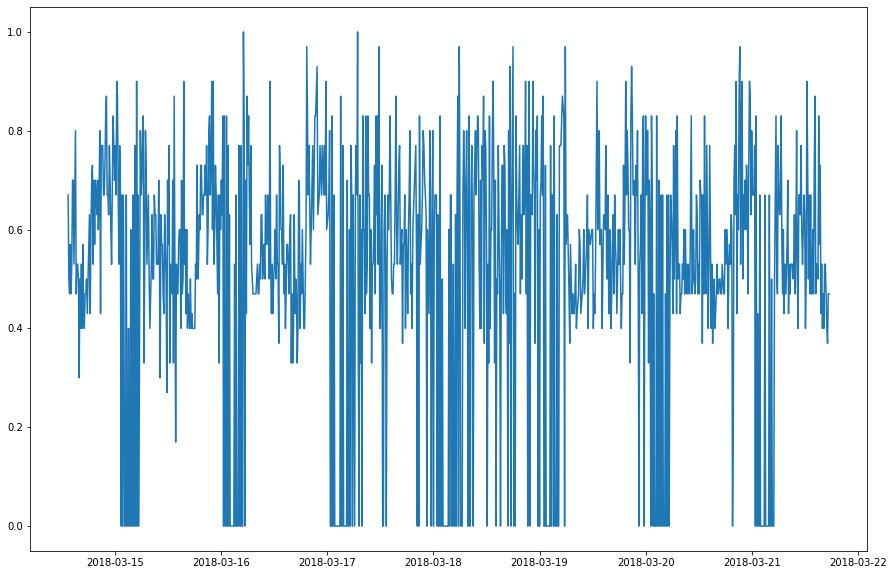

In [21]:
plt.figure(figsize = (15,10))
plt.plot(tt['TIME'], tt['Cong']);

In [22]:
tt.loc[tt['Cong']==0.0]

,TIME,Cong
16978,2018-03-15 01:20:00,0.0
103335,2018-03-15 01:40:00,0.0
78022,2018-03-15 02:10:00,0.0
101910,2018-03-15 02:20:00,0.0
108447,2018-03-15 02:40:00,0.0
...,...,...
74119,2018-03-21 04:10:00,0.0
75764,2018-03-21 04:20:00,0.0
95530,2018-03-21 04:40:00,0.0
91129,2018-03-21 04:50:00,0.0


In [23]:
tt['Cong'] = tt['Cong'].replace(0.0, 0.50)

In [24]:
tt.loc[tt['Cong']==0.0]

,TIME,Cong


In [25]:
tt.shape

(1001, 2)

In [26]:
tt = tt.set_index('TIME').asfreq('10Min')

In [27]:
tt.shape

(1034, 1)

In [28]:
tt.head(20)

,Cong
TIME,
2018-03-14 13:20:00,0.67
2018-03-14 13:30:00,0.50
2018-03-14 13:40:00,0.47
2018-03-14 13:50:00,0.57
2018-03-14 14:00:00,0.47
2018-03-14 14:10:00,0.53
2018-03-14 14:20:00,0.70
2018-03-14 14:30:00,0.70
2018-03-14 14:40:00,0.53


In [29]:
tt.groupby([tt.index.day, tt.index.hour]).transform(lambda x: x.fillna(x.mean()))

,Cong
TIME,
2018-03-14 13:20:00,0.67
2018-03-14 13:30:00,0.50
2018-03-14 13:40:00,0.47
2018-03-14 13:50:00,0.57
2018-03-14 14:00:00,0.47
...,...
2018-03-21 16:50:00,0.47
2018-03-21 17:00:00,0.40
2018-03-21 17:10:00,0.37


In [30]:
tt.loc[tt['Cong']>0]

,Cong
TIME,
2018-03-14 13:20:00,0.67
2018-03-14 13:30:00,0.50
2018-03-14 13:40:00,0.47
2018-03-14 13:50:00,0.57
2018-03-14 14:00:00,0.47
...,...
2018-03-21 16:50:00,0.47
2018-03-21 17:00:00,0.40
2018-03-21 17:10:00,0.37


In [31]:
tt.tail(5)

,Cong
TIME,
2018-03-21 16:50:00,0.47
2018-03-21 17:00:00,0.40
2018-03-21 17:10:00,0.37
2018-03-21 17:20:00,0.47
2018-03-21 17:30:00,0.47


In [32]:
for i, row in tt.iterrows():
#     a=0.0
    
    if row.Cong>0.0:
        pass
    else:
        print(row.Cong)
        b=0.5
#         print(row.Index)
        tt.at[i,'Cong']=b

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [33]:
train = tt.iloc[:746]
test = tt.iloc[746:]

fitted_model = ExponentialSmoothing(train['Cong'], trend='mul',seasonal= 'add',seasonal_periods=144).fit()

C:\Users\T_Tan\anaconda3\envs\keras-gpu\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\T_Tan\anaconda3\envs\keras-gpu\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\T_Tan\anaconda3\envs\keras-gpu\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [34]:
test_predictions = fitted_model.forecast(288)

In [35]:
test_predictions


2018-03-19 17:40:00    0.470284
2018-03-19 17:50:00    0.514126
2018-03-19 18:00:00    0.556437
2018-03-19 18:10:00    0.494779
2018-03-19 18:20:00    0.485972
                         ...   
2018-03-21 16:50:00    0.493890
2018-03-21 17:00:00    0.543925
2018-03-21 17:10:00    0.466637
2018-03-21 17:20:00    0.569388
2018-03-21 17:30:00    0.541020
Freq: 10T, Length: 288, dtype: float64

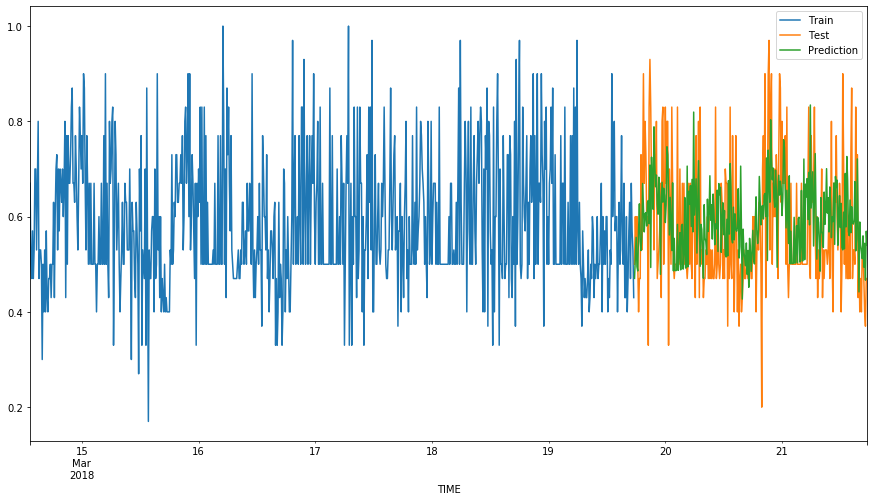

In [36]:
train['Cong'].plot(legend=True,label='Train',figsize=(15,8))
test['Cong'].plot(legend=True,label='Test')
test_predictions.plot(legend=True,label='Prediction')

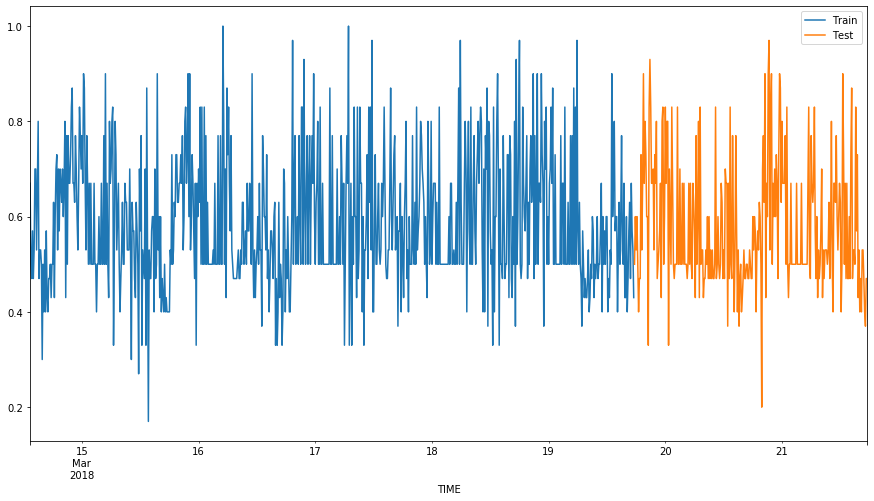

In [37]:
train['Cong'].plot(legend=True,label='Train',figsize=(15,8))
test['Cong'].plot(legend=True,label='Test')
# test_predictions.plot(legend=True,label='Prediction')

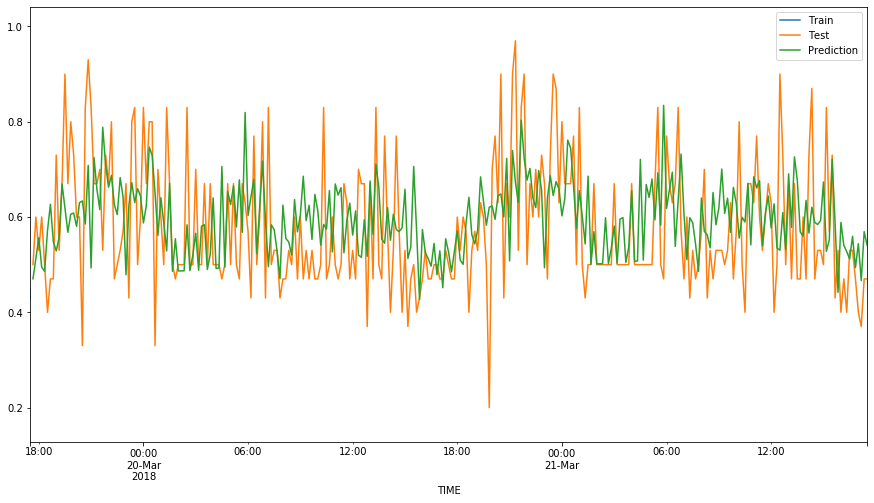

In [38]:
train['Cong'].plot(legend=True,label='Train',figsize=(15,8))
test['Cong'].plot(legend=True,label='Test')
test_predictions.plot(legend=True,label='Prediction',xlim=['2018-03-19 17:30:00','2018-03-21 17:30:00'])

In [39]:
pred_mse = mse(test['Cong'], test_predictions)
pred_rmse = rmse(test['Cong'], test_predictions)

In [41]:
print(pred_mse)
print(pred_rmse)

0.017390518497889477
0.13187311514440492


# See the seasonality and Trend using Seasonal Decomposition 

In [42]:
decompfreq = 6*24
decomposition = sm.tsa.seasonal_decompose(tt.values, period=decompfreq)
trend = decomposition.trend

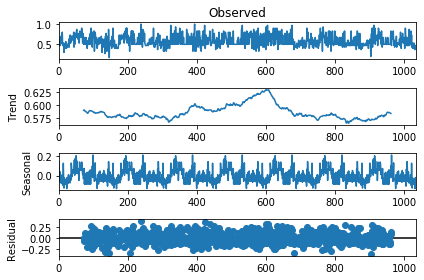

In [43]:
decomposition.plot();

## Dickey–Fuller test method

In [44]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [45]:
adf_test(tt)

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.958257e+00
p-value                 9.307278e-10
# lags used             8.000000e+00
# observations          1.025000e+03
critical value (1%)    -3.436746e+00
critical value (5%)    -2.864364e+00
critical value (10%)   -2.568274e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Run auto arima to get best model result for p,q,d and seasonality

In [41]:
stepwise_fit = auto_arima(tt['Cong'], maxiter=10, seasonal=True, d=None, trace=True, m=144, error_action='ignore', suppress_warnings=True, stepwise=True)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 144); AIC=3716.783, BIC=3756.313, Fit time=37.795 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 144); AIC=-1178.447, BIC=-1168.564, Fit time=0.129 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 144); AIC=2413.923, BIC=2433.688, Fit time=22.841 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 144); AIC=-1195.465, BIC=-1175.700, Fit time=21.970 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 144); AIC=23247.954, BIC=23272.660, Fit time=23.965 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 144); AIC=-1168.595, BIC=-1153.771, Fit time=0.228 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 2, 144); AIC=-1178.948, BIC=-1154.242, Fit time=175.250 seconds


MemoryError: Unable to allocate 664. MiB for an array with shape (290, 290, 1035) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels/tsa/statespace/_kalman_smoother.pyx", line 946, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
MemoryError: ((290, 290, 1035), dtype('float64'))


AttributeError: Memoryview is not initialized

In [ ]:
stepwise_fit.summary()

### Fit sariman according to auto arima order. 

In [46]:
model = SARIMAX(tt['Cong'], order=(0,0,1), seasonal_order=(0,0,1,144), enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                Cong   No. Observations:                 1034
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 144)   Log Likelihood                -243.193
Date:                             Sat, 04 Apr 2020   AIC                            492.386
Time:                                     23:34:54   BIC                            507.210
Sample:                                 03-14-2018   HQIC                           498.011
                                      - 03-21-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6110      0.028     21.565      0.000       0.555       0.667
ma.S.L144      0.6985      0.043     16.184      0.000       0.614       0.783
sigma2         0.0854      0.005     18.298      0.000       0.076       0.095
===================================================================================
Ljung-Box (Q):                      685.09   Jarque-Bera (JB):                 2.62
Prob(Q):                              0.00   Prob(JB):                         0.27
Heteroskedasticity (H):               0.93   Skew:                             0.12
Prob(H) (two-sided):                  0.53   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=True).rename('SARIMA(0,0,1)(0,0,1,144) Predictions')

[Text(0, 0.5, 'Congestion Ratio'), Text(0.5, 0, '')]

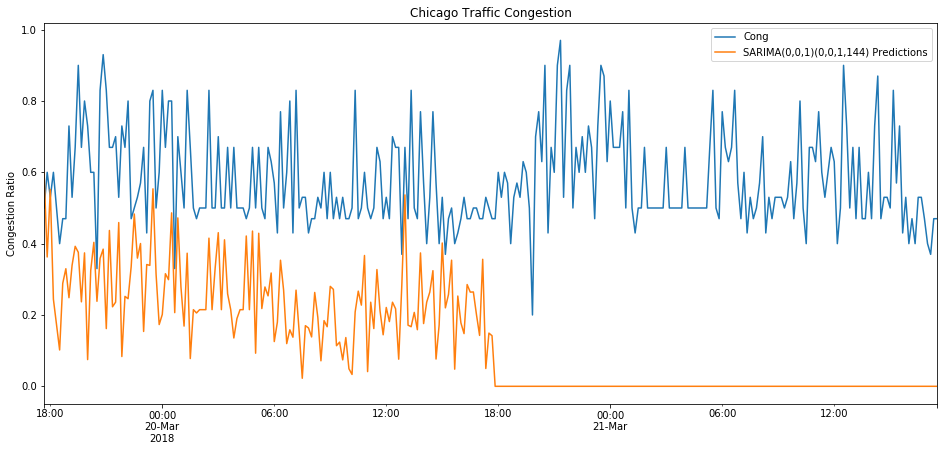

In [48]:
title='Chicago Traffic Congestion'
ylabel='Congestion Ratio'
xlabel=''

ax = test['Cong'].plot(legend=True,figsize=(16,7),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [49]:
error1 = mse(test['Cong'], predictions)
error2 = rmse(test['Cong'], predictions)

In [50]:
print(error1)
print(error2)

0.2430442175237788
0.49299514959457647


In [51]:
model = SARIMAX(tt['Cong'],order=(0,0,1),seasonal_order=(0,0,1,144))
results = model.fit()
fcast = results.predict(len(tt),len(tt)+36,typ='levels').rename('SARIMA(0,0,1)(0,0,1,144) Forecast')

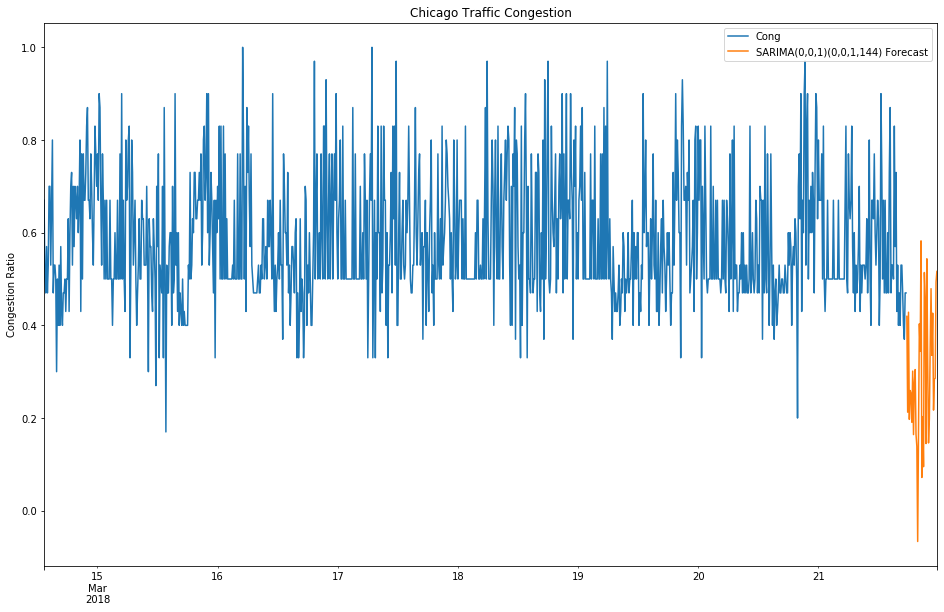

In [52]:
title = 'Chicago Traffic Congestion'
ylabel='Congestion Ratio'
xlabel=''

ax = tt.plot(legend=True,figsize=(16,10),title=title)
fcast.plot(legend=True, xlim=['2018-03-18 17:30:00','2018-03-21 17:30:00'])
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);